# Hi :)

----

# Import libraries

In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from filterpy.monte_carlo import systematic_resample

# Loading the data

In [2]:
data= pd.read_excel('pendulum_noisy_data.xlsx')
true_values= data[['x1', 'x2', 'x3', 'x4']].values
y1= data['y1']
y2= data['y2']

# Initialization

In [20]:
T= 0.01
m= 0.1
M= 5.0
g= 9.81
l= 0.72
Q= np.diag([15, 9.6, 10.0, 17.0])
R= np.diag([19.2, 16.8])

# Seting the random seed
np.random.seed(84)

def fx(x, dt):
    x1= x[0]
    x2= x[1]
    x3= x[2]
    x4= x[3]
    u= 0
    wk= np.random.multivariate_normal(mean= np.zeros(4), cov= Q)
    dx1= x2
    dx2= (u * np.cos(x1) - (M + m) * g * np.sin(x1) + m * l * np.cos(x1) * np.sin(x1) * x2**2) / (m * l * np.cos(x1)**2 - (M + m) * l)
    dx3= x4
    dx4= (u + m * l * np.sin(x1) * x2**2 - m * g * np.cos(x1) * np.sin(x1)) / (M + m - m * np.cos(x1)**2)

    return np.array([x1 + dx1 * dt, x2 + dx2 * dt, x3 + dx3 * dt, x4 + dx4 * dt]) + wk

def SIRPF(x_posterior, y):

    H= np.array([[1,0,0,0],
                 [0,0,1,0]])
    X_prior= []
    weight= []
    
    # 2a - Use incoming particles, not X0
    for i in x_posterior:
        x= fx(i, T)
        X_prior.append(x)
    
    # 2b - Compute weights
    for j in range(len(x_posterior)):
        residual= y - H @ X_prior[j]
        w= np.exp(-0.5 * residual.T @ np.linalg.inv(R) @ residual)
        weight.append(w)

    # 2c - Normalize weights
    weight= np.array(weight)
    weight_sum= np.sum(weight)
    weight += 1.e-200
    weight /= weight_sum

    # 2d - Resample
    X_prior= np.array(X_prior)
    indexes= systematic_resample(weight)
    resample_particle= X_prior[indexes]

    # 2e - Estimate state
    x_hat= np.mean(resample_particle, axis= 0)
    return x_hat, resample_particle

def main_PF(N):
    mean= np.array([-1.0, 1.0, -1.0, 1.0])  
    cov= np.diag([0.5, 1.0, 0.5, 1.0])      
    X0= np.random.multivariate_normal(mean= mean, cov= cov,size= N)

    z= np.array([y1[0], y2[0]])
    x_estimate= []

    new_x, new_particle= SIRPF(X0, z)
    x_estimate.append(new_x)

    for i in range(1, len(y1)):
        z= np.array([y1[i], y2[i]])
        new_x, new_particle= SIRPF(new_particle, z)
        x_estimate.append(new_x)
    return np.array(x_estimate)

def rmse(x_estimate):
    # Compute RMSE for each state variable
    x_estimate= pd.DataFrame(x_estimate).values
    rmse= np.sqrt(np.mean((x_estimate - true_values)**2, axis= 0))

    # Display RMSE for each state
    for i in range(4):
        print(f"RMSE for x{i + 1}: {rmse[i]:.4f}")

def visualization(x_estimate, N):
    # Plot estimated vs true states
    time= np.arange(10001) * 0.001
    labels= ['x1', 'x2', 'x3', 'x4']

    plt.figure(figsize= (12, 8))
    for i in range(4):
        plt.subplot(2, 2, i + 1)
        plt.plot(time, x_estimate[:, i], label= 'True')
        plt.plot(time, true_values[:, i], label= 'Estimated', linestyle= '--')
        plt.title(labels[i])
        plt.xlabel('Time (s)')
        plt.ylabel(labels[i])
        plt.legend()
        plt.grid()
    plt.suptitle(f'"Particle Filter implementation - {N} Particles"', fontsize= 18)
    plt.tight_layout()
    plt.show()

# PF

In [16]:
N= 10
x_estimate= main_PF(N)

# RMSE

In [18]:
rmse(x_estimate)

RMSE for x1: 4.8576
RMSE for x2: 185.4848
RMSE for x3: 4.7281
RMSE for x4: 467.5105


# Visualization

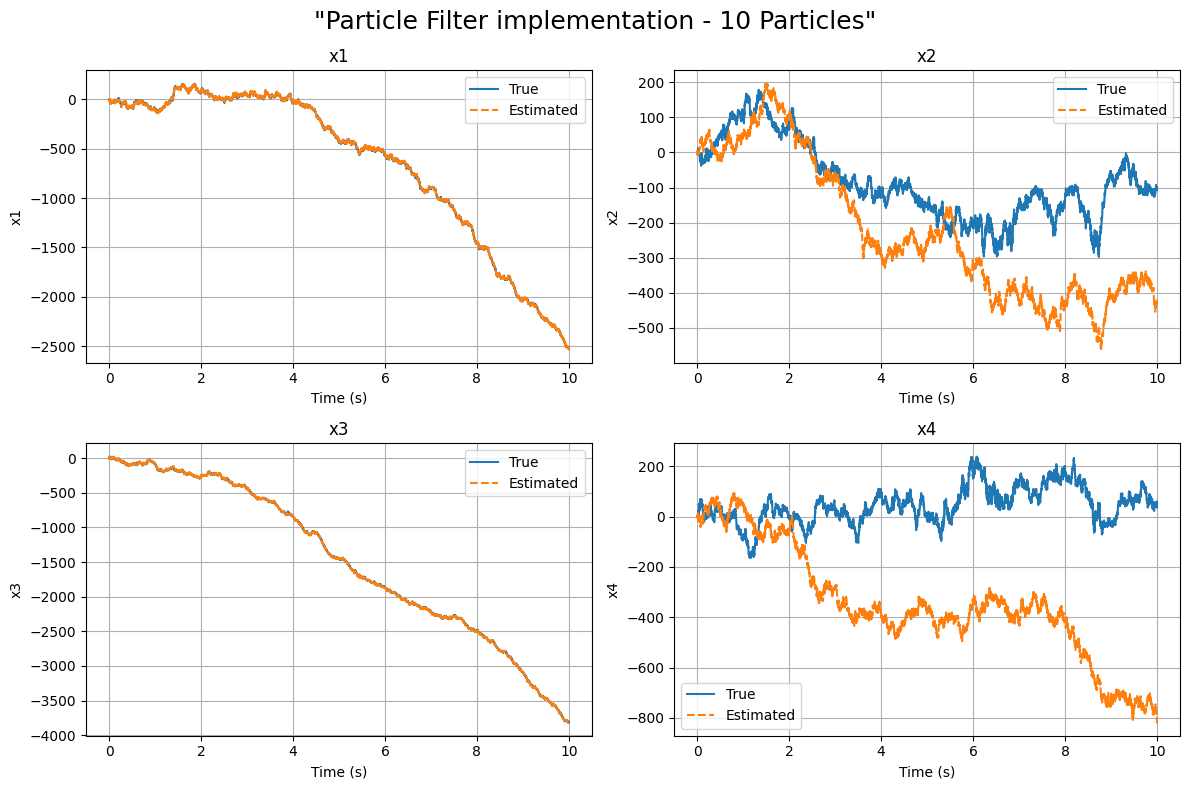

In [21]:
visualization(x_estimate, N)

# Different amount of Particles

10

In [ ]:
N= 10
x_estimate= main_PF(N)
rmse(x_estimate)
visualization(x_estimate, N)

100

In [ ]:
N= 100
x_estimate= main_PF(N)
rmse(x_estimate)
visualization(x_estimate, N)

1000

In [ ]:
N= 1000
x_estimate= main_PF(N)
rmse(x_estimate)
visualization(x_estimate, N)

2000

In [ ]:
N= 2000
x_estimate= main_PF(N)
rmse(x_estimate)
visualization(x_estimate, N)